In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy
import matplotlib.pyplot as plt
import astropy.constants

In [2]:
# Time to sweep
t_start = Time('2019-10-07 00:00:00')
t_end = Time('2019-10-13 00:00:00')

# Observer location
ea4gpz = EarthLocation(lat = 40.595865*u.deg, lon = -3.699069*u.deg, height=800*u.m)

# Antenna pointing
azimuth = 138.92*u.deg
elevation = 34.23*u.deg

In [3]:
t_step = 10*u.s
t = t_start + np.arange((t_end-t_start)/t_step)*t_step

dish_pointing = SkyCoord(AltAz(az = azimuth * np.ones(t.size), alt = elevation*np.ones(t.size),\
                               location = ea4gpz, obstime = t))
sun = astropy.coordinates.get_sun(t)
separation = sun.separation(dish_pointing)

In [4]:
events = list()
for s in t[separation < 1*u.deg]:
    if len(events) == 0 or s - events[-1][1] > 10*u.min:
        events.append([s,s])
    else:
        events[-1][1] = s

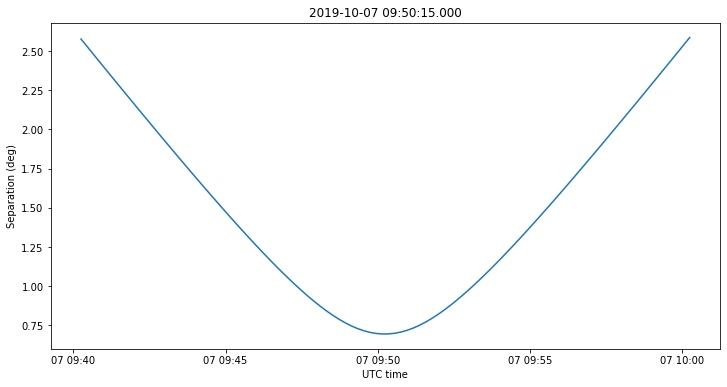

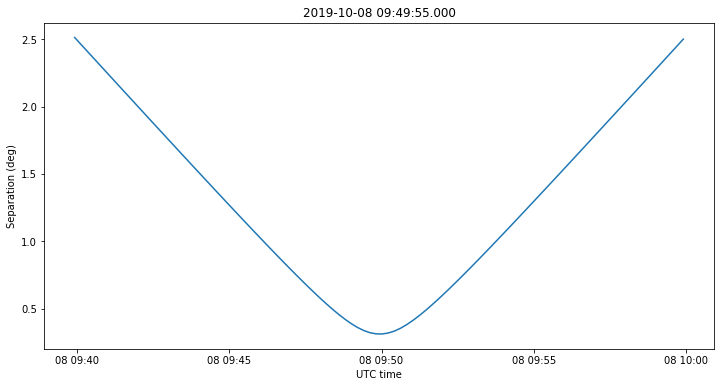

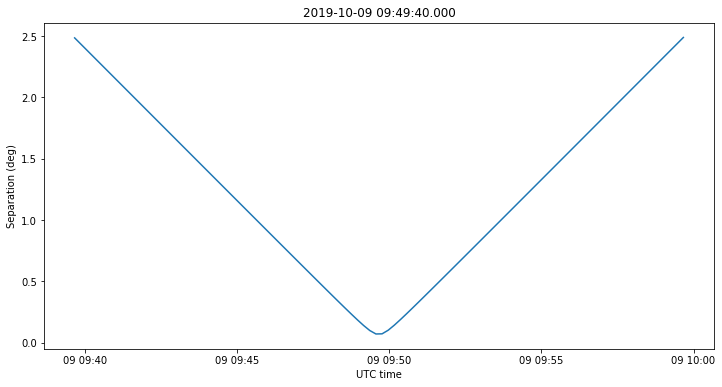

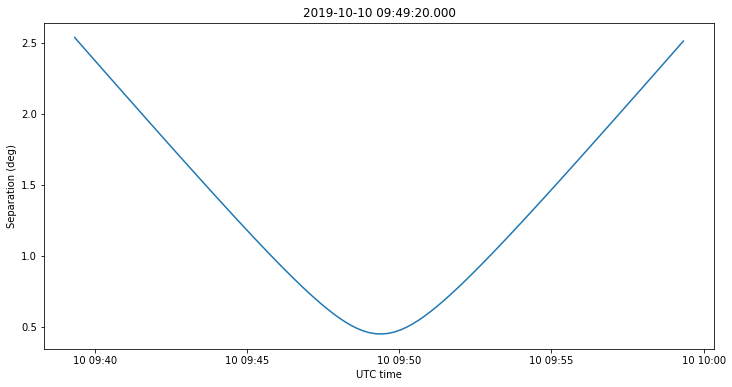

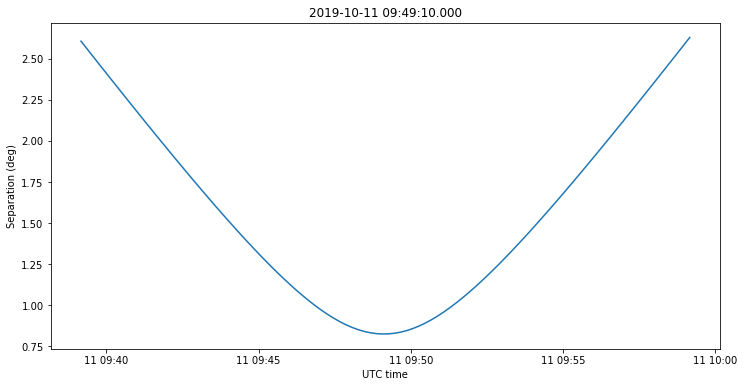

In [5]:
for event in events:
    t0 = event[0] + 0.5*(event[1]-event[0]) 
    time = t0 + np.linspace(-1,1,100) * 10 * u.min
    dish_pointing = SkyCoord(AltAz(az = azimuth * np.ones(time.size), alt = elevation * np.ones(time.size),\
                               location = ea4gpz, obstime = time))
    plt.figure(figsize = (12,6), facecolor = 'w')
    plt.plot(time.datetime, astropy.coordinates.get_sun(time).separation(dish_pointing))
    plt.title(t0)
    plt.xlabel('UTC time')
    plt.ylabel('Separation (deg)')

In [6]:
noise_pwr = np.fromfile('power_f32_2019-10-06T18:50:20.697445', dtype = 'float32')
noise_t = np.datetime64('2019-10-06T18:50:20.697445') + np.arange(noise_pwr.size) * np.timedelta64(1, 's')

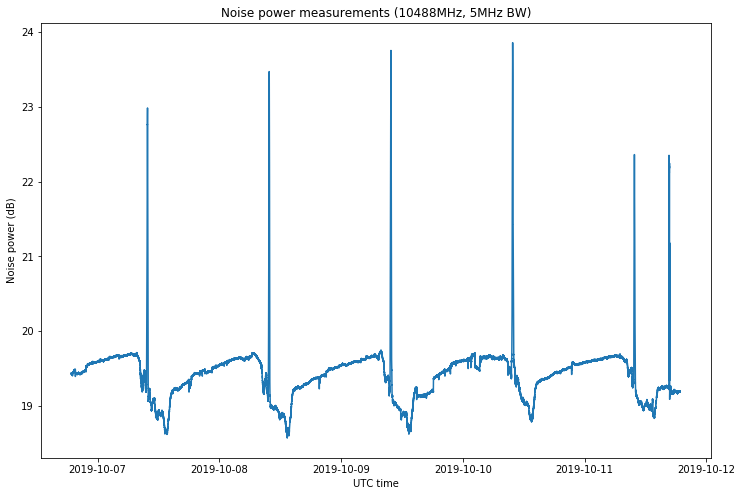

In [99]:
secs_in_day = 3600 * 24
plt.figure(figsize = (12,8), facecolor = 'w')
plt.plot(noise_t[2:secs_in_day * 5], 10*np.log10(noise_pwr[2:secs_in_day * 5]))
plt.title('Noise power measurements (10488MHz, 5MHz BW)')
plt.xlabel('UTC time')
plt.ylabel('Noise power (dB)');

In [37]:
pwr_by_day = noise_pwr[:secs_in_day * 5].reshape((-1, secs_in_day))
t_by_day = noise_t[:secs_in_day * 5].astype('<M8[us]').reshape((-1, secs_in_day))
peak_loc = np.argmax(pwr_by_day, axis = 1)
span = peak_loc.reshape((-1,1)) + np.arange(-1000,1000).reshape((1,-1))
peaks_by_day = pwr_by_day[np.tile(np.reshape(np.arange(pwr_by_day.shape[0]), (-1,1)), (1,span.shape[1])), span]
t_peaks_by_day = t_by_day[np.tile(np.reshape(np.arange(pwr_by_day.shape[0]), (-1,1)), (1,span.shape[1])), span]
normalization = np.average(peaks_by_day[:,1750:], axis = 1)
peaks_by_day /= normalization.reshape((-1,1))

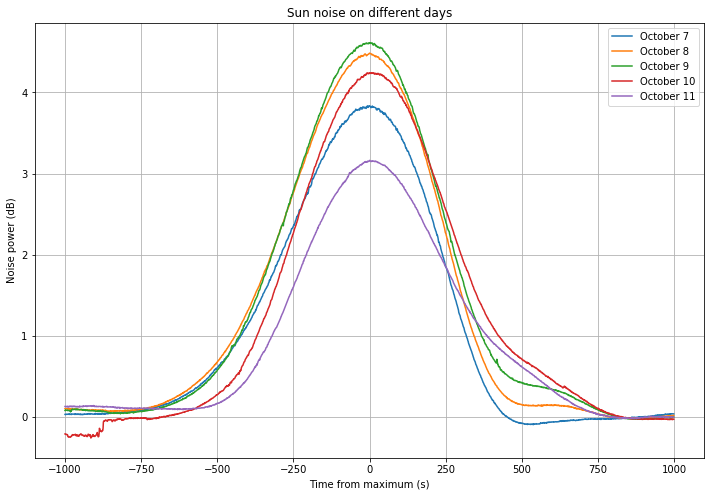

In [88]:
plt.figure(figsize = (12,8), facecolor = 'w')
plt.plot(np.arange(-1000,1000), 10*np.log10(peaks_by_day).transpose())
plt.legend([f'October {n+7}' for n in range(peaks_by_day.shape[0])])
plt.grid()
plt.title('Sun noise on different days')
plt.xlabel('Time from maximum (s)')
plt.ylabel('Noise power (dB)');

In [39]:
10*np.log10(np.max(peaks_by_day))

4.6124690771102905

In [41]:
max_times = Time(t_peaks_by_day[:,peaks_by_day.shape[1]//2])
trace_times = Time(t_peaks_by_day)
sun_max = astropy.coordinates.get_sun(max_times).transform_to(AltAz(location = ea4gpz, obstime = max_times))
sun_trace = astropy.coordinates.get_sun(trace_times).transform_to(AltAz(location = ea4gpz, obstime = trace_times))

Spherical angle between sun_max[2] and sun_max[3]

In [112]:
angle = np.arccos(np.sin(sun_max[2].alt) * np.sin(sun_max[3].alt) + np.cos(sun_max[2].alt) * np.cos(sun_max[3].alt) * np.cos(sun_max[2].az - sun_max[3].az))
np.rad2deg(angle)

<Quantity 0.37997821 deg>

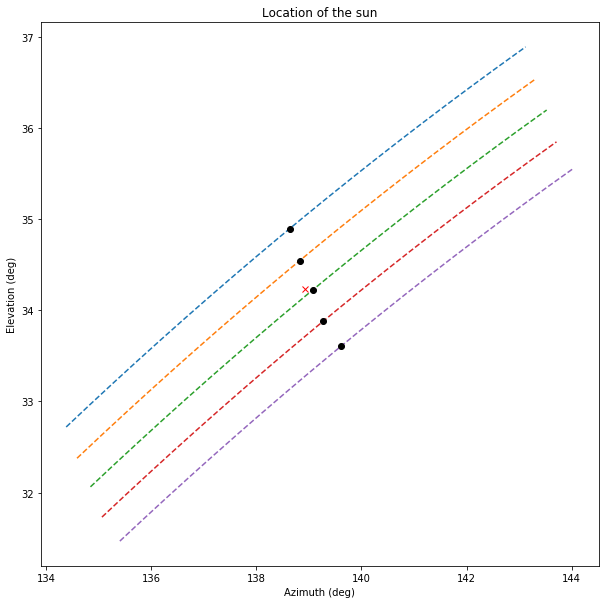

In [101]:
plt.figure(figsize = (10,10), facecolor = 'w')
plt.plot(sun_trace.az.T, sun_trace.alt.T, '--')
plt.plot(sun_max.az, sun_max.alt, 'o', color = 'black')
plt.plot(azimuth, elevation, 'x', color = 'red')
plt.title('Location of the sun')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Elevation (deg)');

In [44]:
measure_sig = peaks_by_day[2,500:1001] - 1
measure_t = Time(t_peaks_by_day[2,500:1001])
dish_pointing = SkyCoord(AltAz(az = azimuth * np.ones(measure_t.size), alt = elevation*np.ones(measure_t.size),\
                               location = ea4gpz, obstime = measure_t))
sun = astropy.coordinates.get_sun(measure_t)
measure_theta = sun.separation(dish_pointing)
cut = np.argmin(measure_theta)
measure_theta = measure_theta[:cut][::-1]
measure_sig = measure_sig[:cut][::-1]

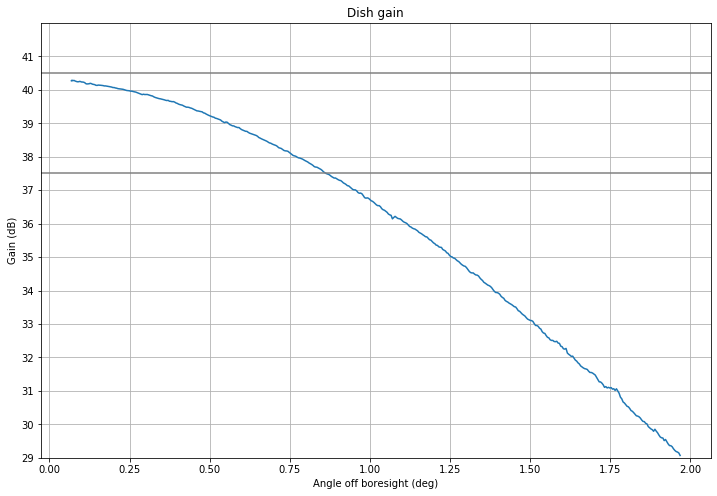

In [45]:
plt.figure(figsize = (12,8), facecolor = 'w')
gain_average = np.trapz(measure_sig * 2 * np.pi * np.sin(measure_theta), x = measure_theta.rad)/(4*np.pi)
plt.plot(measure_theta, 10*np.log10(measure_sig/gain_average))
plt.grid()
plt.yticks(np.arange(29,42))
plt.ylim((29,42))
plt.axhline(40.5, color = 'grey')
plt.axhline(40.5-3, color = 'grey')
plt.ylabel('Gain (dB)')
plt.xlabel('Angle off boresight (deg)')
plt.title('Dish gain');

In [119]:
sfu = 1e4 * u.Jy
flux = 297.2 * sfu
freq = 10488e6 * u.Hz
G = 10**(40.5/10)
aperture = G * freq.to(u.m, equivalencies = u.spectral())**2/(4*np.pi)

In [120]:
aperture

<Quantity 0.72953509 m2>

In [48]:
dish_area = (0.6*u.m)**2*np.pi
efficiency = aperture/dish_area
efficiency

<Quantity 0.64505064>

In [126]:
gamma_atm = 10**(-0.22/10/(np.sin(elevation)))
10*np.log10(gamma_atm)

<Quantity -0.39109974>

In [170]:
gamma_cover = 10**(-0.1/10)
gamma_pointing = 10**(-0.4/10)

In [171]:
L = 1 + 0.38 * (0.5 / 1.7)**2 # http://www.setileague.org/articles/g-t.htm
gamma_beam = 1/L
10*np.log10(gamma_b)

-0.14046492708840014

In [172]:
gamma = gamma_atm * gamma_cover * gamma_pointing * gamma_beam
10*np.log10(gamma)

<Quantity -1.03156466>

In [173]:
psd = (0.5 * gamma * flux * aperture).to(u.W/u.Hz)
psd

<Quantity 8.54886635e-21 W / Hz>

In [174]:
(psd / astropy.constants.k_B).to(u.K)

<Quantity 619.19208443 K>

In [175]:
10*np.log10(np.max(peaks_by_day-1))

2.76995450258255

In [176]:
sky_noise = (psd / astropy.constants.k_B).to(u.K) / np.max(peaks_by_day-1)
sky_noise

<Quantity 327.21255557 K>

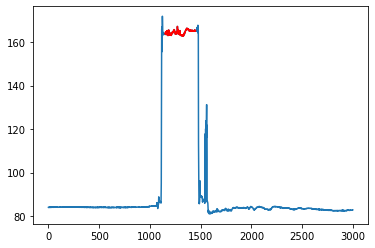

In [177]:
t_amb = (21 + 273.15) * u.K
y_factor = noise_pwr[423000:][:3000]
plt.plot(y_factor)
sel = slice(1150,1450)
plt.plot(np.arange(y_factor.size)[sel], y_factor[sel], color = 'red')

In [178]:
Y = 10*np.log10(np.average(y_factor[sel])/np.average(y_factor[:1000]))
t_cold = 15 * u.K
t_hot = t_amb
t_sys = (t_hot - 10**(Y/10)*t_cold)/(10**(Y/10)-1)
Y, t_hot, t_sys, t_sys + t_cold

(2.91527658700943,
 <Quantity 294.15 K>,
 <Quantity 276.77956761 K>,
 <Quantity 291.77956761 K>)

In [179]:
10**(Y/10)*sky_noise - t_hot

<Quantity 346.11184012 K>

In [210]:
additional_losses = 10**(-0.05)

In [211]:
sky_noise*additional_losses

<Quantity 291.62849712 K>

In [214]:
system_noise = 10**(Y/10)*additional_losses*sky_noise - t_hot
system_noise

<Quantity 276.48396566 K>

In [213]:
sky_noise*additional_losses - (10**(Y/10)*additional_losses*sky_noise - t_hot)

<Quantity 15.14453146 K>

In [215]:
10*np.log10(1 + system_noise / (290*u.K))

<Quantity 2.90789624>

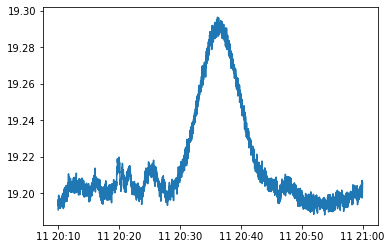

In [81]:
moon_sel = (noise_t >= np.datetime64('2019-10-11T20:10')) & (noise_t <= np.datetime64('2019-10-11T21:00'))
plt.plot(noise_t[moon_sel], 10*np.log10(noise_pwr[moon_sel]))